In [4]:
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
import scipy as sp
import sklearn as sk
import time
from dypac import Dypac
from nilearn import image, plotting, datasets
from nilearn.input_data import NiftiLabelsMasker, NiftiMapsMasker, NiftiMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn.decomposition import DictLearning, CanICA
from scipy.stats import pearsonr

# Define paths to HCP data

In [5]:
subjects = [108828, 114419, 118932, 130316, 131722, 151223, 151526, 156637, 178950,180129, 201111]

path = './HCP_subjects/{}/MNINonLinear/Results/rfMRI_REST2_LR/rfMRI_REST2_LR_hp2000_clean.nii'

# Get Atlas

### Harvard Oxford
Using this atlas based on the paper 'Benchmarking ...' https://www.sciencedirect.com/science/article/pii/S1053811919301594 as it seemed to perform the best on HCP data for the predefined atlases (as opposed to data driven parcellation).

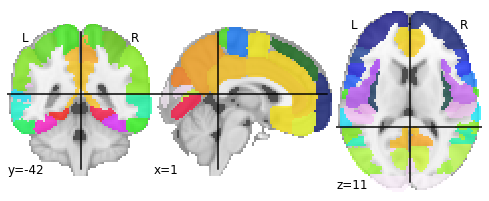

In [6]:
# I don't truly understand the different datasets the string speicifies
# (I think) symmetric_split doubles the number of regions which makes sense since some function is lateralized
ho = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm',symmetric_split=True)
ho_filename = ho.maps
ho_labels = ho.labels

plotting.plot_roi(ho_filename)

# Load image into time series
https://nilearn.github.io/user_guide.html

In [7]:
#harvard oxford
ho_masker = NiftiLabelsMasker(labels_img=ho_filename, standardize=True,
                           memory='nilearn_cache', verbose=5)
ho_time_series = []
for sub in subjects:
    sub_path = path.format(sub) 
    ts = ho_masker.fit_transform(sub_path)
    np.savetxt('./harvard_oxford_results/ho_time_series/ho_time_series{}.csv'.format(sub), ts)
    ho_time_series.append(ts)

[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image('/home/annabelle/nilearn_data/fsl/data/atlases/HarvardOxford/HarvardOxford-cortl-maxprob-thr25-2mm.nii.gz')
[Memory]0.0s, 0.0min    : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image('/home/annabelle/nilearn_data/fsl/data/atlases/HarvardOxford/HarvardOxford-cortl-maxprob-thr25-2mm.nii.gz')
[Memory]0.2s, 0.0min    : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.2s, 0.0min
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image('/home/annabelle/nilearn_data/fsl/data/atlases/HarvardOxford/HarvardOxford-cortl-maxprob-thr25-2mm.nii.gz')
________________________________________________________________________________
[Memory] Calling nilearn.input_data.base_masker.filter_and_extract...
filter_and_extract('./HCP_subjects/118932/MNINonLinear/Resu

# Produce connectivity matrices

### correlation

In [8]:
correlation = ConnectivityMeasure(kind = 'correlation')
ho_correlation = []
i=0
for ts in ho_time_series:
    corr = correlation.fit_transform([ts])[0]
    ho_correlation.append(corr)
    np.savetxt('./harvard_oxford_results/ho_correlation_matrices/ho_correlation{}.csv'.format(subjects[i]),corr)
    i = i +1
#difumo_correlation_matrix = correlation.fit_transform([difumo_time_series])[0]

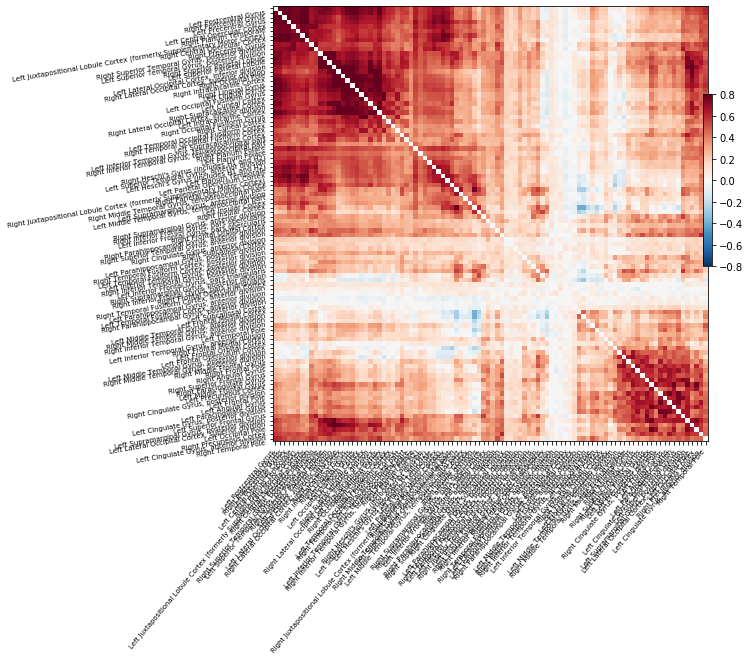

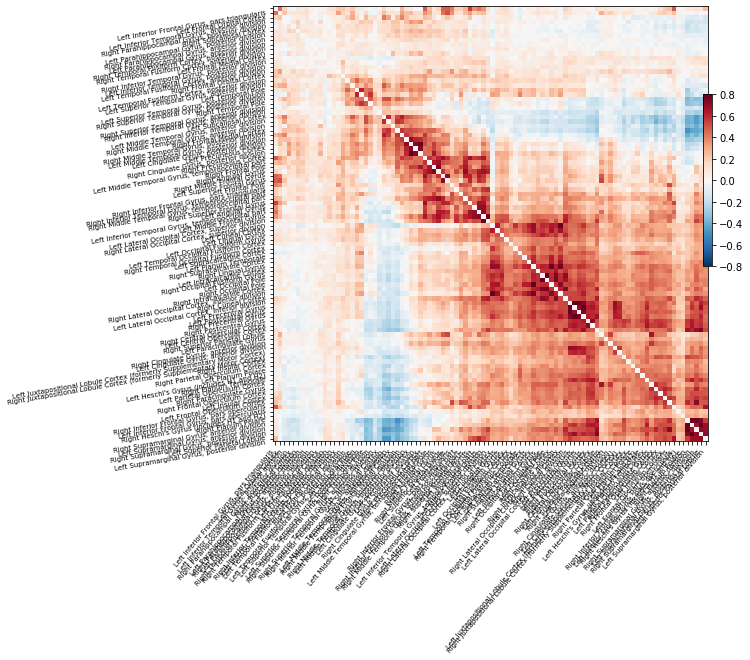

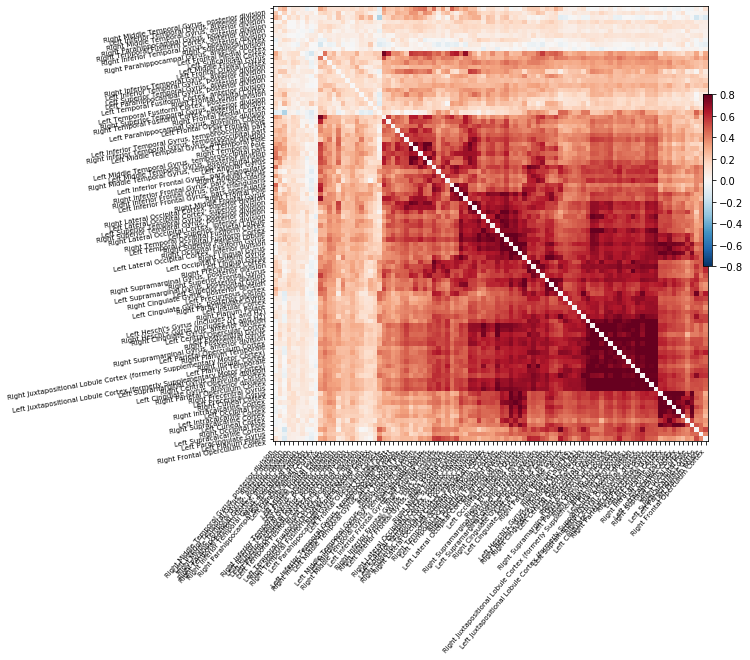

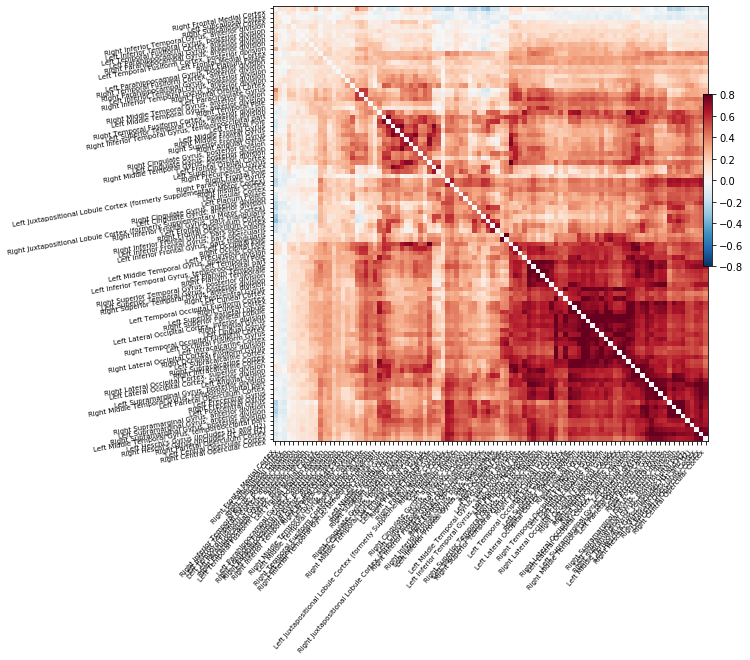

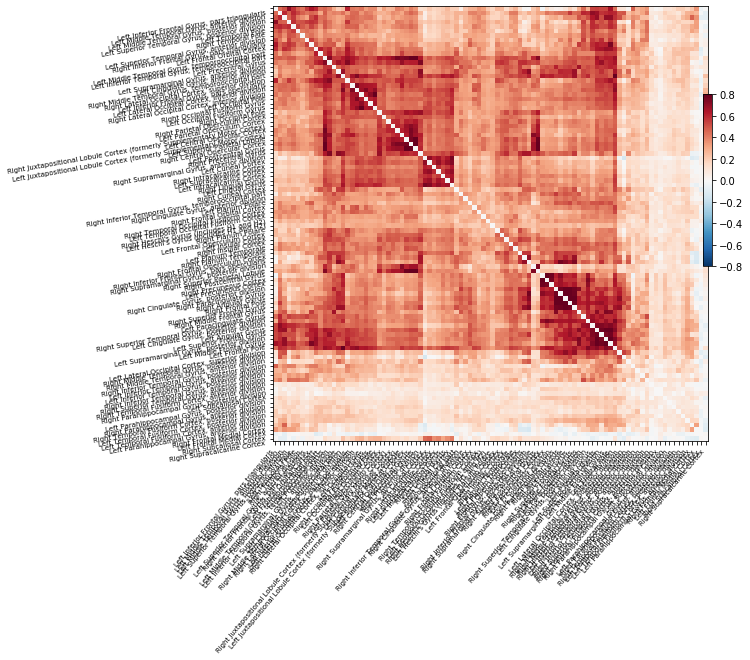

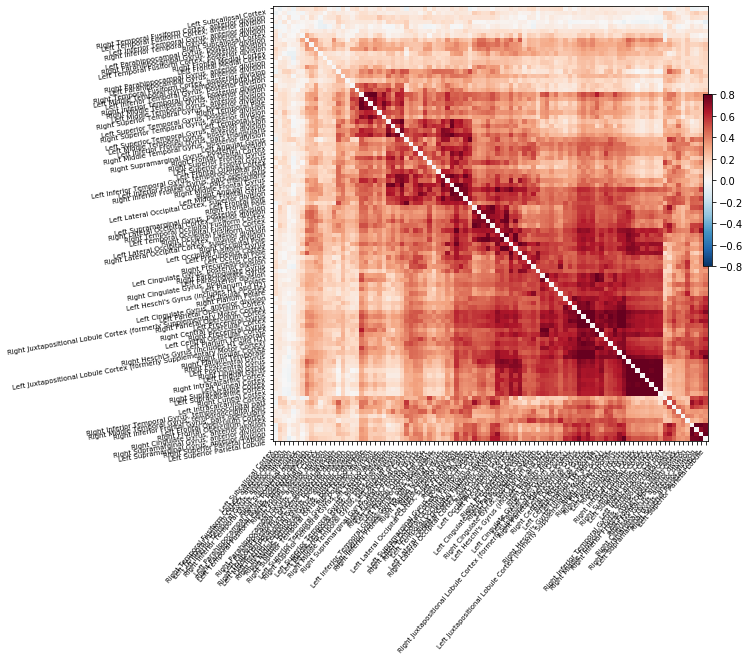

In [8]:
# Mask the main diagonal for visualization:
#labels start w background, skip first
# matrices are ordered for block-like representation
for corr in ho_correlation:
    np.fill_diagonal(corr, 0)
    plotting.plot_matrix(corr, figure=(10, 8), labels=ho_labels[1:],
                     vmax=0.8, vmin=-0.8, reorder=True)

### tangent space embedding

In [9]:
tangent = ConnectivityMeasure(kind = 'tangent')
ho_tangent = tangent.fit_transform(ho_time_series)
#difumo_tangent = tangent.fit_transform(difumo_time_series)
#ho_tangent.shape

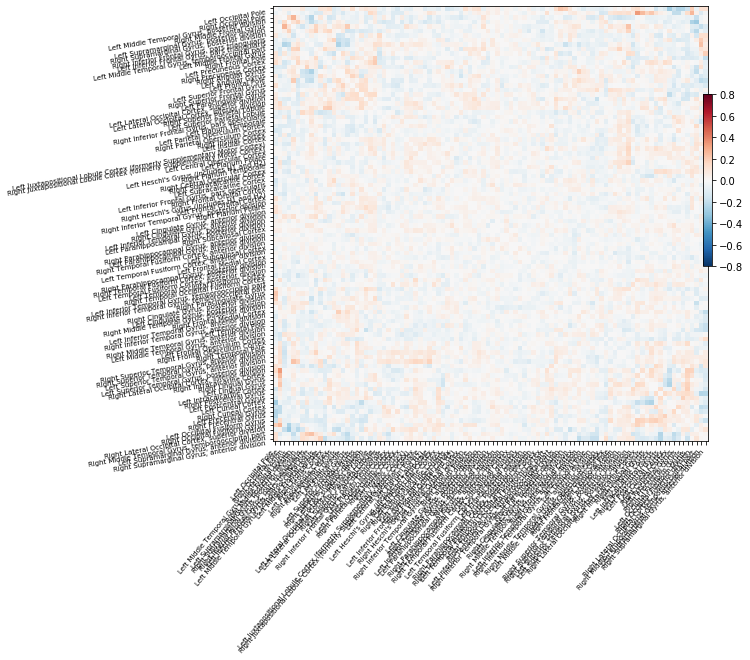

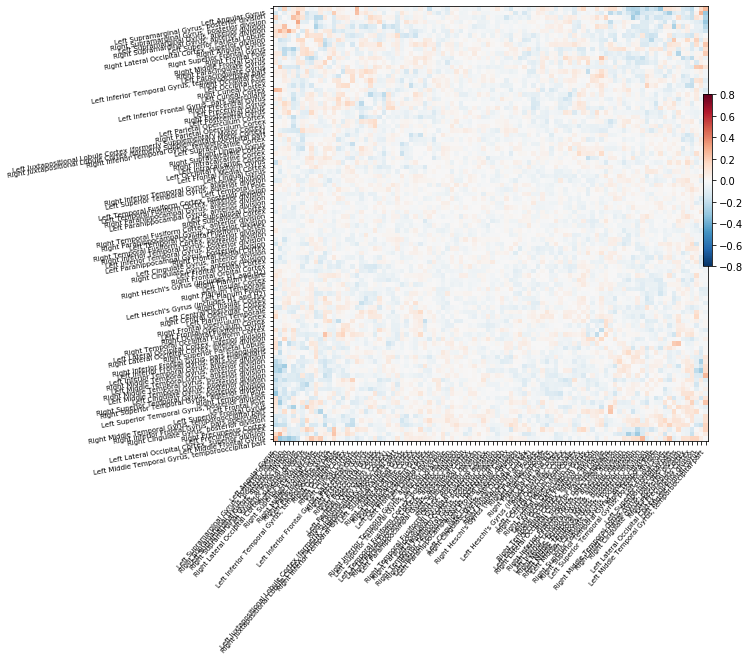

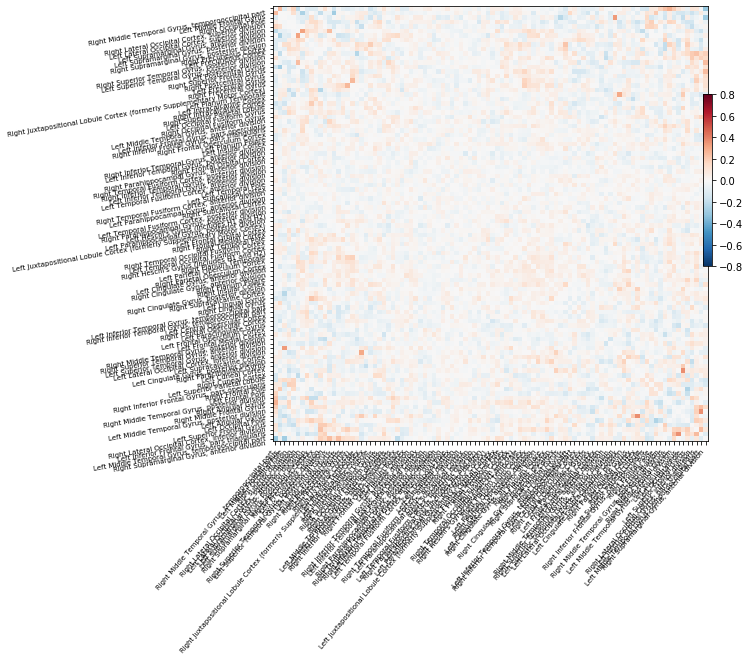

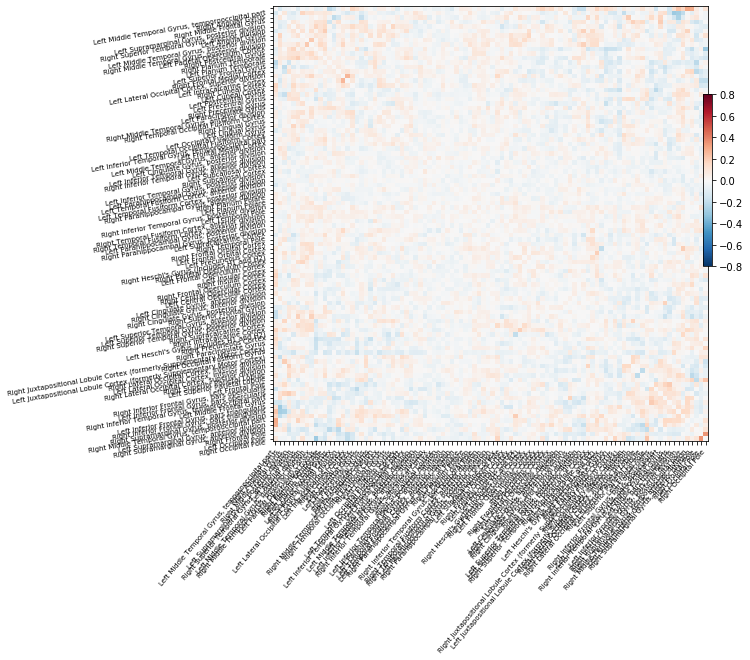

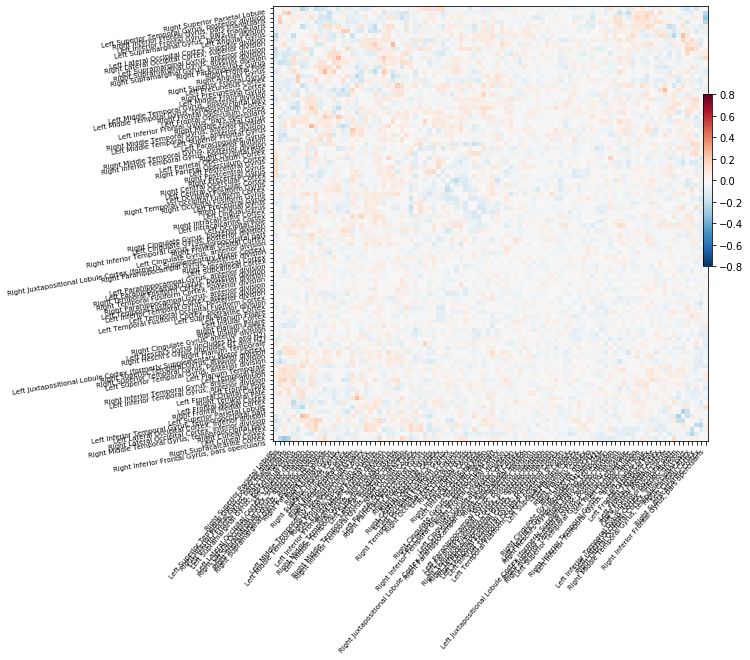

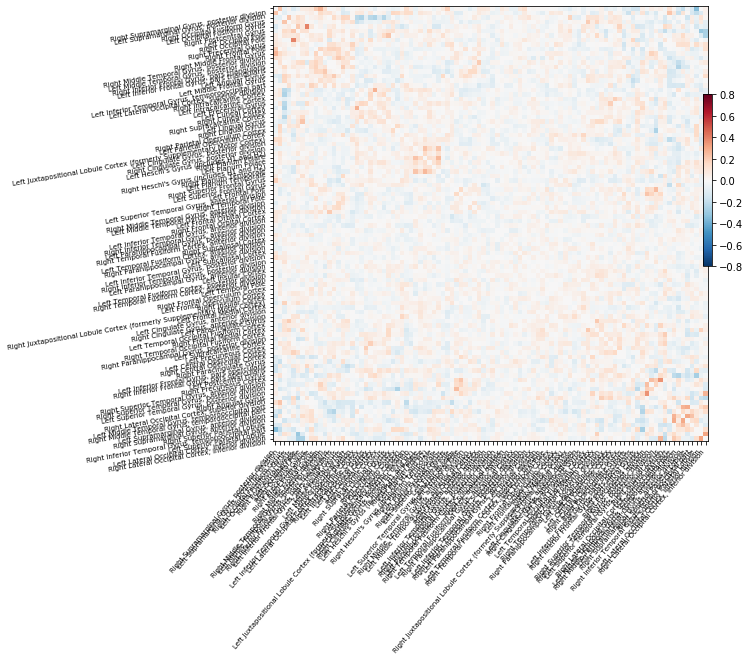

In [31]:
for i in range(len(subjects)):
    np.fill_diagonal(ho_tangent[i], 0)
    plotting.plot_matrix(ho_tangent[i], figure=(10, 8), labels=ho_labels[1:],
                     vmax=0.8, vmin=-0.8, reorder=True)
#plotting.plot_matrix(ho_tangent.mean_, figure=(10, 8), labels=ho_labels[1:],
#                     vmax=0.8, vmin=-0.8, reorder=True)

# Visualize Connectomes

In [9]:
ho_coords = plotting.find_parcellation_cut_coords(labels_img=ho_filename)
view = plotting.view_connectome(ho_correlation[0], ho_coords, edge_threshold='80%', edge_cmap = 'Spectral')
view

In [29]:
view = plotting.view_connectome(ho_tangent[0], ho_coords, edge_threshold='95%', edge_cmap = 'Spectral')
view

/home/annabelle/miniconda3/lib/python3.7/site-packages/nilearn/reporting/html_document.py:60: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))


# Predict Neuroticism

In [10]:
#load subject ids and neuroticism scores into a dataframe
nscores = {114419:25,118932:25,130316:28,178950:28,151526:29,156637:30,201111:31,151223:33,108828:35,131722:39,180129:43}
df = pd.DataFrame.from_dict(nscores,orient = 'index', columns = ['n_score'])
df.loc[subjects].sort_index()

n_score
108828       35
114419       25
118932       25
130316       28
131722       39
151223       33
151526       29
156637       30
178950       28
180129       43
201111       31

[32.126457 33.315155 32.74652  29.975328 32.261242 31.385193 31.196705
 31.90385  32.693237 30.314383 31.28666 ]
31.454545454545453


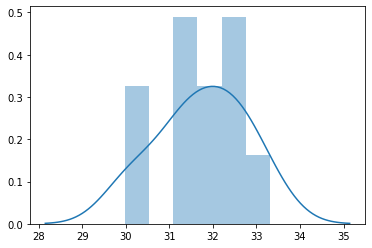

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

X = [x.flatten() for x in ho_tangent]
y = df.loc[subjects].sort_index()['n_score'].tolist()

#X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =1)

#print(y_test)

model = LinearRegression()
#vectorize arrays for model to accept
#model.fit([x.flatten() for x in X_train],y_train)
#model.predict([x.flatten() for x in X_test])
print(cross_val_predict(model,X,y))
print(np.mean(y))
sns.distplot(cross_val_predict(model,X,y),bins=6)

#looks like predictions are essentially the mean

# Explore different approaches to parcellation

### DiFuMo
Using this atlas as I couldn't find the MODL precomputed atlas refererred to by 'Benchmarking...' and this atlas is recent, has multiple resolutions, and a very clear and useful github repo.

In [4]:
"""Function to fetch DiFuMo atlases.

   Direct download links from OSF:

   dic = {64: https://osf.io/wjum7/download,
          128: https://osf.io/kdfg3/download,
          256: https://osf.io/vza2y/download,
          512: https://osf.io/a23gw/download,
          1024: https://osf.io/jpdum/download,
          }
"""
import os
#import pandas as pd

from sklearn.datasets.base import Bunch

from nilearn.datasets.utils import (_fetch_files,
                                    _get_dataset_dir)


def fetch_difumo(dimension=64, resolution_mm=2, data_dir=None):
    """Fetch DiFuMo brain atlas

    Parameters
    ----------
    dimension : int
        Number of dimensions in the dictionary. Valid resolutions
        available are {64, 128, 256, 512, 1024}.

    resolution_mm : int
        The resolution in mm of the atlas to fetch. Valid options
        available are {2, 3}.

    data_dir : string, optional
        Path where data should be downloaded. By default,
        files are downloaded in home directory.

    Returns
    -------
    data: sklearn.datasets.base.Bunch
        Dictionary-like object, the interest attributes are :

        - 'maps': str, 4D path to nifti file containing regions definition.
        - 'labels': string list containing the labels of the regions.

    References
    ----------
    Dadi, K., Varoquaux, G., Machlouzarides-Shalit, A., Gorgolewski, KJ.,
    Wassermann, D., Thirion, B., Mensch, A.
    Fine-grain atlases of functional modes for fMRI analysis,
    Paper in preparation
    """
    dic = {64: 'wjum7',
           128: 'kdfg3',
           256: 'vza2y',
           512: 'a23gw',
           1024: 'jpdum',
           }
    valid_dimensions = [64, 128, 256, 512, 1024]
    valid_resolution_mm = [2, 3]
    if dimension not in valid_dimensions:
        raise ValueError("Requested dimension={} is not available. Valid "
                         "options: {}".format(dimension, valid_dimensions))
    if resolution_mm not in valid_resolution_mm:
        raise ValueError("Requested resolution_mm={} is not available. Valid "
                         "options: {}".format(resolution_mm,
                                              valid_resolution_mm))
    url = 'https://osf.io/{}/download'.format(dic[dimension])
    opts = {'uncompress': True}

    csv_file = os.path.join('{0}', 'labels_{0}_dictionary.csv')
    if resolution_mm != 3:
        nifti_file = os.path.join('{0}', 'maps.nii.gz')
    else:
        nifti_file = os.path.join('{0}', '3mm', 'resampled_maps.nii.gz')

    files = [(csv_file.format(dimension), url, opts),
             (nifti_file.format(dimension), url, opts)]

    dataset_name = 'difumo_atlases'

    data_dir = _get_dataset_dir(data_dir=None, dataset_name=dataset_name,
                                verbose=1)

    # Download the zip file, first
    files = _fetch_files(data_dir, files, verbose=2)
    labels = pd.read_csv(files[0])

    # README
    readme_files = [('README.md', 'https://osf.io/u5xhn/download',
                    {'move': 'README.md'})]
    if not os.path.exists(os.path.join(data_dir, 'README.md')):
        _fetch_files(data_dir, readme_files, verbose=2)

    # Python resampling script
    script_files = [('resample_dictionaries.py', 'https://osf.io/ezr37/download',
                    {'move': 'resample_dictionaries.py'})]
    if not os.path.exists(os.path.join(data_dir, 'resample_dictionaries.py')):
        _fetch_files(data_dir, script_files, verbose=2)

    return Bunch(maps=files[1], labels=labels)

/home/annabelle/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


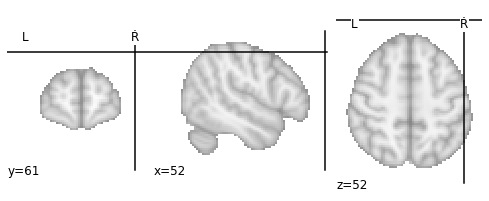

In [8]:
difumo_maps = fetch_difumo(dimension=64).maps
#dont understand the dimensionality of the difumo map, why 4d?
first_map = image.index_img(difumo_maps,0)
plotting.plot_roi(first_map)

In [ ]:
#difumo (this is VERY slow)

difumo_masker = NiftiMapsMasker(maps_img=difumo_maps, verbose=10)
difumo_time_series = []
for sub in subjects:
    sub_path = path.format(sub) 
    ts = difumo_masker.fit_transform(sub_path)
    np.savetxt('difumo_time_series{}'.format(sub), ts)
    difumo_time_series.append(ts)

[NiftiMapsMasker.fit_transform] loading regions from /home/annabelle/nilearn_data/difumo_atlases/64/maps.nii.gz
Resampling maps
[NiftiMapsMasker.transform_single_imgs] Loading data from ./HCP_subjects/108828/MNINonLinear/Results/rfMRI_REST2_LR/rfMRI_REST2_LR_hp2000_clean.nii
[NiftiMapsMasker.transform_single_imgs] Extracting region signals


### Dypac / dynamic states of parcellation
https://www.biorxiv.org/content/10.1101/2020.03.02.972760v1.full

Absolutely no way this is going to run locally

In [ ]:
img_section = image.load_img(paths[0], slice(0,5))
model = Dypac(n_clusters=10, n_states=20, verbose=1, n_init=1, n_init_aggregation=1, n_replications=1, 
              detrend=True, standardize=True, n_batch=1, threshold_sim=0)
model.fit(img_section)

### Dynamic mode decomposition
https://www.frontiersin.org/articles/10.3389/fncom.2019.00075/full

https://github.com/kunert/DMD_RSN

# Similarity network fusion
https://www.biorxiv.org/content/10.1101/2020.03.05.979526v1
* combine different characterizations of connectivity matrices with SNF?